<a href="https://colab.research.google.com/github/jsedoc/ConceptorDebias/blob/master/Experiments/Conceptors/Gradient_Based_Conceptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

%matplotlib inline
dtype = torch.float
device = torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Tesla K80'

# Gradient Approach To Conceptors

### Initializing Old Conceptors and Data

In [0]:
## Old Conceptors Implementations 

def get_conceptor(x, alpha):    
    N = x.shape[1] - 1
    cov = (x @ x.T)*(1/N)
    return cov @ inv(cov + (1/alpha**2)*np.eye(x.shape[0]))

def improved_conceptor(X, alpha = 1):
    N = X.shape[1] 
    means = np.mean(X, axis = 1)
    stds = np.std(X,axis = 1)
    X = X - means[:,None]
    X = X / stds[:,None]
    cov = (X @ X.T)*(1/N)
    return cov @ inv(cov + (alpha**(-2))*np.eye(X.shape[0]))

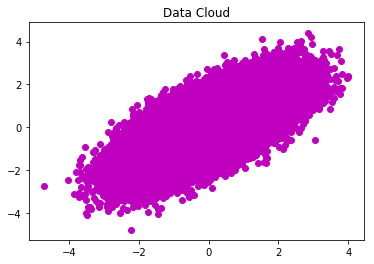

In [0]:
## Generating Dataset

N = 100000
covariance = [[1,0.7],
              [0.7,1]]
X = np.random.multivariate_normal([0,0],covariance,N).T

plt.title('Data Cloud')
plt.scatter(X[0],X[1], c = 'm')
plt.show()
print("\n")

In [0]:
## Checking Old Conceptors
alpha = 1
C = improved_conceptor(X, alpha)
print(C)
print(np.linalg.norm(X - C @ X)**2/N + np.linalg.norm(C)**2)

[[0.4300064  0.19973959]
 [0.19973959 0.4300064 ]]
0.8587059413064972


### Setup Gradient Based Conceptor

In [0]:
learning_rate = 0.1
x = torch.tensor(X.T, device = device, dtype = dtype) 
y = x.clone().detach()

W = torch.rand(2,2, device = device, dtype = dtype, requires_grad = True)

for t in range(10001):
    
    y_pred = x.mm(W)
    
    l2_reg = W.norm(2).pow(2)
    loss = (1/N)*(y_pred - y).pow(2).sum() + l2_reg
    
    if(t%5000 == 0): print(t,': ', loss.item())
    
    loss.backward()
    with torch.no_grad():
        W -= learning_rate *(1/(0.001*t+1)) * W.grad
        W.grad.zero_()
        
print(W.data)



0 :  1.3641281127929688
5000 :  0.8587023019790649
10000 :  0.8587023019790649
tensor([[0.4300, 0.1996],
        [0.1996, 0.4287]], device='cuda:0')


In [0]:
model = torch.nn.Sequential(torch.nn.Linear(2,2, bias = False))
model.cuda()
loss_fn = torch.nn.MSELoss(reduction = 'mean') 

for t in range(15001):
    
    y_pred = model(x)
    
#     loss = loss_fn(y_pred,y)
    l2_reg = None
    for param in model.parameters():
        if l2_reg is None:
            l2_reg = param.norm(2).pow(2)
        else:
            l2_reg = l2_reg + param.norm(2)
        
    loss = (1/N)*(y_pred - y).pow(2).sum() + l2_reg
    if(t%5000 == 0): print(t,': ', loss.item())
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate*(1/(0.001*t+1))  * param.grad
            

for param in model.parameters():
    print(param.data)    
    
# optimizer = optim.SGD(net.parameters(),lr = 0.01, weight_decay = 1)

0 :  1.7786717414855957
5000 :  0.8587022423744202
10000 :  0.8587022423744202
15000 :  0.8587022423744202
tensor([[0.4300, 0.1996],
        [0.1996, 0.4287]], device='cuda:0')


In [0]:
## NOT conceptor

notx = model(x).detach_()
noty = y.clone().detach()
notmodel = torch.nn.Sequential(torch.nn.Linear(2,2, bias = False))
notmodel.cuda()

learning_rate = 0.1
for t in range(15001):
    
    y_pred = notmodel(notx)
        
    loss = (1/N)*(y_pred - noty).pow(2).sum() 
    if(t%5000 == 0): print(t,': ', loss.item()) 
    loss.backward()
    
    with torch.no_grad():
        for param in notmodel.parameters():
            param -= learning_rate*(1/(0.001*t+1)) * param.grad
        notmodel.zero_grad()


for param in notmodel.parameters():
    print(param.data)    

for param in notmodel.parameters():
    for param2 in model.parameters():
        print(param.mm(param2))

0 :  3.239119529724121
5000 :  3.4366858017165214e-06
10000 :  8.017530461756905e-08
15000 :  1.1178273418011031e-08
tensor([[ 2.9667, -1.3814],
        [-1.3814,  2.9757]], device='cuda:0')
tensor([[9.9990e-01, 9.2432e-05],
        [9.6727e-05, 9.9990e-01]], device='cuda:0', grad_fn=<MmBackward>)


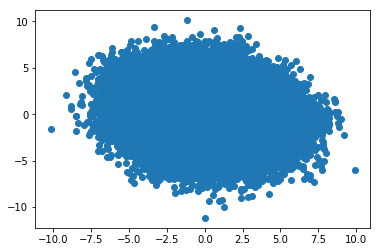

In [0]:
result = notmodel(x).detach().cpu()
plt.scatter(result[:,0],result[:,1])
plt.show()

### Nonlinear Conceptors Using Autoencoders (INCOMPLETE)

In [0]:
class Conceptor(nn.Module):

    def __init__(self, size):
        super(Conceptor, self).__init__()    
        self.fc1 = nn.Linear(size,2)
        self.fc2 = nn.Linear(2,2)
        self.fc3 = nn.Linear(2,size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

conceptor = Conceptor(2)
conceptor.cuda()
learn_rate = 0.1

for t in range(3001):
    pred_y = conceptor(x)
    
    l2 = None
    for param in conceptor.parameters():
        if l2 is None:
            l2 = param.norm(2).pow(2)
        else:
            l2 = l2 + param.norm(2).pow(2)
    loss = (1/N)*(pred_y-y).pow(2).sum() + l2/100
    if(t%300 == 0): print(t,': ', loss.item()) 
        
    conceptor.zero_grad()
    loss.backward()

    with torch.no_grad():
        for param in conceptor.parameters():
            param -= learning_rate * param.grad    

0 :  2.136806011199951
300 :  0.45019644498825073
600 :  0.4390798807144165
900 :  0.43529826402664185
1200 :  0.43382346630096436
1500 :  0.433147132396698
1800 :  0.4327890872955322
2100 :  0.4325529932975769
2400 :  0.4323546886444092
2700 :  0.43214017152786255
3000 :  0.4318634867668152


In [0]:
notC = Conceptor(2)
notC.cuda()
cX = conceptor(x).clone().detach()

for t in range(3001):
    pred_y = notC(cX)
    loss = (1/N)*(pred_y-y).pow(2).sum()
    if(t%300 == 0): print(t,': ', loss.item()) 
                
    notC.zero_grad()
    loss.backward()    
    with torch.no_grad():
        for param in notC.parameters():
            param -= learning_rate * param.grad  

0 :  4.0406813621521
300 :  0.5552231073379517
600 :  0.5536800026893616
900 :  0.5514601469039917
1200 :  0.5549765229225159
1500 :  0.5532590746879578
1800 :  0.5565354228019714
2100 :  0.5537621974945068
2400 :  0.5512833595275879
2700 :  0.5549153089523315
3000 :  0.5533676743507385


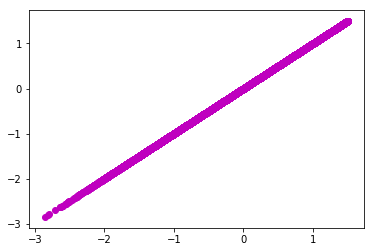

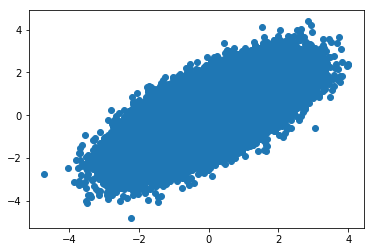

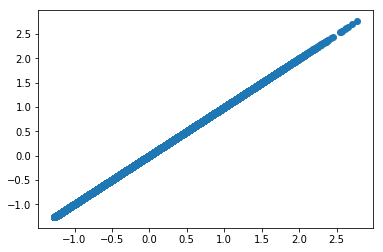

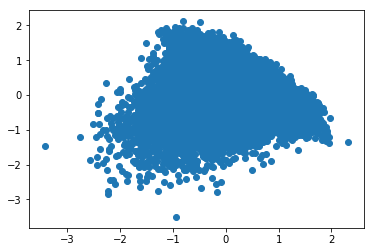

In [0]:
test = np.random.multivariate_normal([0,0],[[1,0],
                                            [0,1]],N)
test = torch.tensor(test, device = device, dtype = dtype) 
testC = conceptor(test).detach().cpu()
plt.scatter(testC[:,0],testC[:,1], c = 'm')
plt.show()

original = xe.detach().cpu()
plt.scatter(original[:,0],original[:,1])
plt.show()

result = notC(x).detach().cpu()
plt.scatter(result[:,0],result[:,1])
plt.show()

what = original - result
plt.scatter(what[:,0],what[:,1])
plt.show()